# Estimate the probability of peaking

In [1]:
!pip install yfinance --upgrade --no-cache-dir

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
# Define the ticker symbol
ticker_symbol = '^NDX'

# Download data
data = yf.download(ticker_symbol, period='5y')


[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate daily returns
data['Returns'] = data['Adj Close'].pct_change()


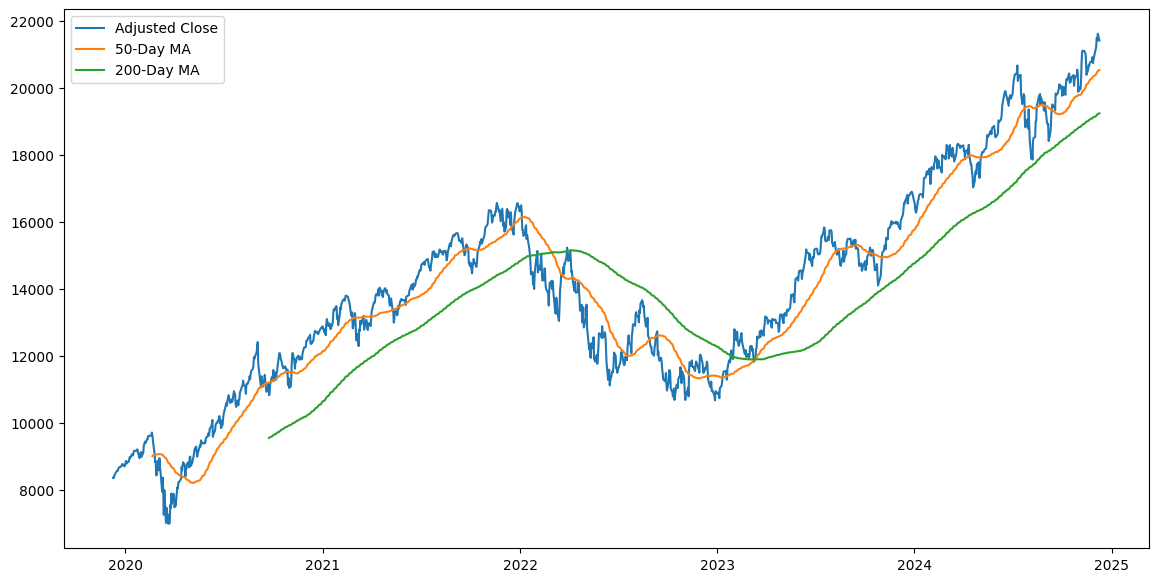

In [4]:
# Calculate 50-day and 200-day moving averages
data['MA50'] = data['Adj Close'].rolling(window=50).mean()
data['MA200'] = data['Adj Close'].rolling(window=200).mean()

# Plot adjusted close price and moving averages
plt.figure(figsize=(14,7))
plt.plot(data['Adj Close'], label='Adjusted Close')
plt.plot(data['MA50'], label='50-Day MA')
plt.plot(data['MA200'], label='200-Day MA')
plt.legend()
plt.show()


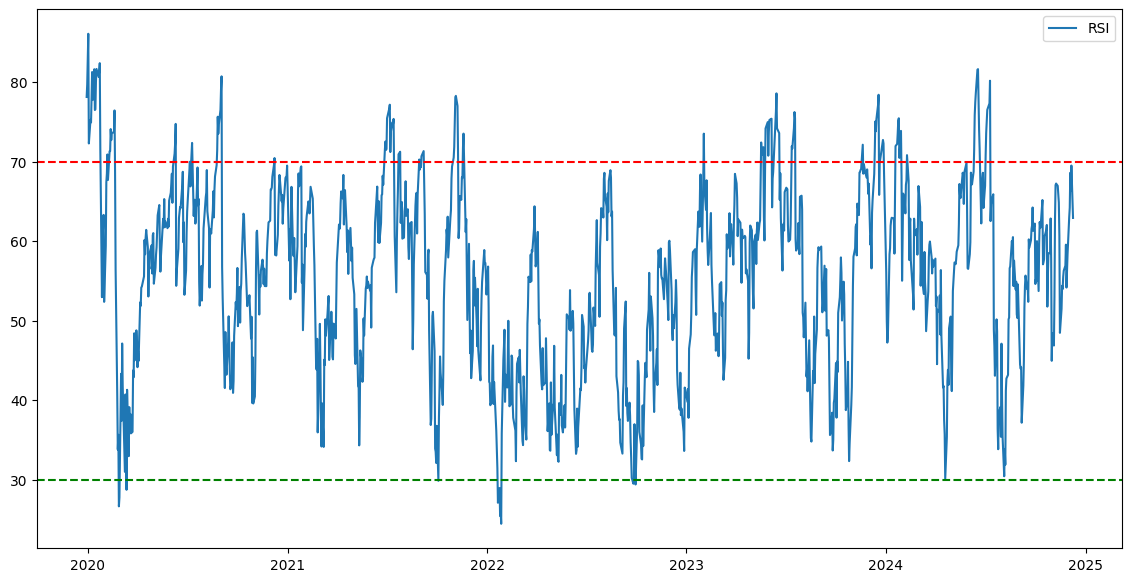

In [5]:
# Define a function to compute RSI
def computeRSI(data, time_window):
    diff = data.diff(1).dropna()
    # Calculate gains and losses
    up_chg = 0 * diff
    down_chg = 0 * diff

    # Positive gains (up) and negative gains (down)
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = -diff[diff < 0]

    # Calculate exponential weighted averages
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()

    rs = up_chg_avg / down_chg_avg
    rsi = 100 - 100 / (1 + rs)
    return rsi

# Calculate 14-day RSI
data['RSI'] = computeRSI(data['Adj Close'], 14)

# Plot RSI chart
plt.figure(figsize=(14,7))
plt.plot(data['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.show()


In [6]:
# Filter dates when RSI exceeds 70
overbought = data[data['RSI'] > 70]

# Calculate future 30-day returns after overbought signals
future_returns = []
for date in overbought.index:
    start_price = data.loc[date]['Adj Close']
    end_date = date + pd.Timedelta(days=30)
    # Check if end_date is within the dataset
    if end_date in data.index:
        end_price = data.loc[end_date]['Adj Close']
        ret = (end_price - start_price) / start_price
        future_returns.append(ret)

# Convert results to a NumPy array
future_returns = np.array(future_returns)

# Calculate the probability of a decline
probability_of_decline = np.mean(future_returns < 0)

print(f"After RSI exceeds 70, the probability of the market declining in the next 30 days is: {probability_of_decline*100:.2f}%")


After RSI exceeds 70, the probability of the market declining in the next 30 days is: 34.72%


# analyze how much the market typically rises after the Relative Strength Index (RSI) reaches 70 before hitting a peak

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical data for the past 10 years
ticker_symbol = '^NDX'
data = yf.download(ticker_symbol, period='10y')

# Drop any rows with missing values
data = data.dropna()


[*********************100%***********************]  1 of 1 completed


In [14]:
# Function to compute RSI
def computeRSI(data, time_window):
    diff = data.diff(1)
    # Calculate gains and losses
    gain = diff.clip(lower=0)
    loss = -1 * diff.clip(upper=0)
    # Calculate average gains and losses
    avg_gain = gain.rolling(window=time_window).mean()
    avg_loss = loss.rolling(window=time_window).mean()
    # Calculate RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI and add it to the DataFrame
data['RSI'] = computeRSI(data['Adj Close'], 14)


In [15]:
# Identify where RSI crosses above 70
data['RSI Signal'] = np.where((data['RSI'].shift(1) < 70) & (data['RSI'] >= 70), 1, 0)

# Get the dates when RSI crosses above 70
rsi_cross_dates = data[data['RSI Signal'] == 1].index


In [16]:
# Set the observation period (60 days)
observation_period = 60

# Initialize a list to store percentage increases
percentage_increases = []

# Loop through each RSI cross date
for date in rsi_cross_dates:
    # Starting price when RSI crosses 70
    start_price = data.loc[date]['Adj Close']
    # Define the end date for the observation period
    end_date = date + pd.Timedelta(days=observation_period)
    # Slice the data for the observation period
    data_subset = data.loc[date:end_date]
    # Check if the subset is not empty
    if not data_subset.empty:
        # Find the maximum price after RSI crosses 70
        max_price = data_subset['Adj Close'].max()
        # Calculate the percentage increase to the maximum price
        percentage_increase = (max_price - start_price) / start_price * 100
        percentage_increases.append(percentage_increase)


In [17]:
# Convert the list to a NumPy array
percentage_increases = np.array(percentage_increases)

# Calculate average and median increases
average_increase = np.mean(percentage_increases)
median_increase = np.median(percentage_increases)

print(f"Average percentage increase after RSI crosses 70: {average_increase:.2f}%")
print(f"Median percentage increase after RSI crosses 70: {median_increase:.2f}%")

# Optional: Display all percentage increases
print("All percentage increases:")
print(percentage_increases)


Average percentage increase after RSI crosses 70: 6.45%
Median percentage increase after RSI crosses 70: 5.91%
All percentage increases:
[[ 2.22810465]
 [ 1.91108787]
 [ 2.93925103]
 [ 0.        ]
 [ 0.45050062]
 [ 6.31794747]
 [ 0.        ]
 [ 8.76408984]
 [ 4.62479311]
 [ 2.27386315]
 [ 4.95856503]
 [ 6.16252117]
 [ 5.27317528]
 [ 1.77204735]
 [ 7.59379432]
 [ 7.22763407]
 [ 5.67321382]
 [ 8.55121685]
 [ 6.21195416]
 [ 1.24438994]
 [ 1.40443464]
 [ 5.85649977]
 [ 5.61249839]
 [ 4.23633539]
 [ 3.45782182]
 [ 8.62777467]
 [ 6.80024367]
 [ 6.58175577]
 [ 5.63777233]
 [ 0.        ]
 [ 5.90792419]
 [ 7.83018586]
 [ 7.40206177]
 [ 4.76980282]
 [ 4.10824118]
 [ 0.15544153]
 [ 9.5559893 ]
 [11.79730458]
 [ 8.49800841]
 [10.15537533]
 [10.44744124]
 [ 6.29990151]
 [ 3.98622867]
 [ 3.30274486]
 [ 0.        ]
 [ 3.60427236]
 [ 2.78378701]
 [ 1.13371022]
 [ 4.69836797]
 [ 5.40931486]
 [ 8.23162149]
 [ 7.56190172]
 [ 8.0636486 ]
 [ 7.93913737]
 [10.09385904]
 [10.96169431]
 [ 0.98872135]
 [21.139

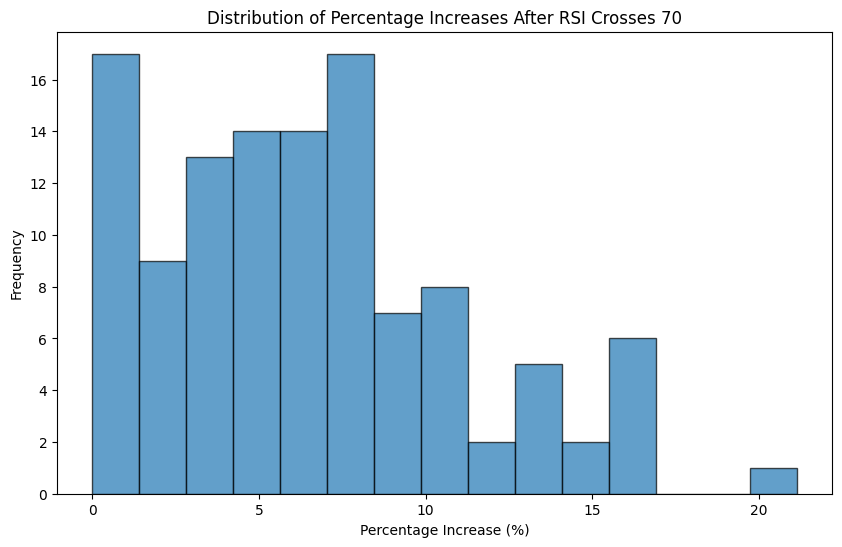

In [18]:
# Plot the histogram
plt.figure(figsize=(10,6))
plt.hist(percentage_increases, bins=15, edgecolor='k', alpha=0.7)
plt.title('Distribution of Percentage Increases After RSI Crosses 70')
plt.xlabel('Percentage Increase (%)')
plt.ylabel('Frequency')
plt.show()


# analyze the typical decline over the next 14 days after the market enters overbought conditions (RSI crosses above 70) and then starts to decline.

[*********************100%***********************]  1 of 1 completed


Average percentage decline over 14 days after decline starts: 0.40%
Median percentage decline over 14 days after decline starts: 1.04%


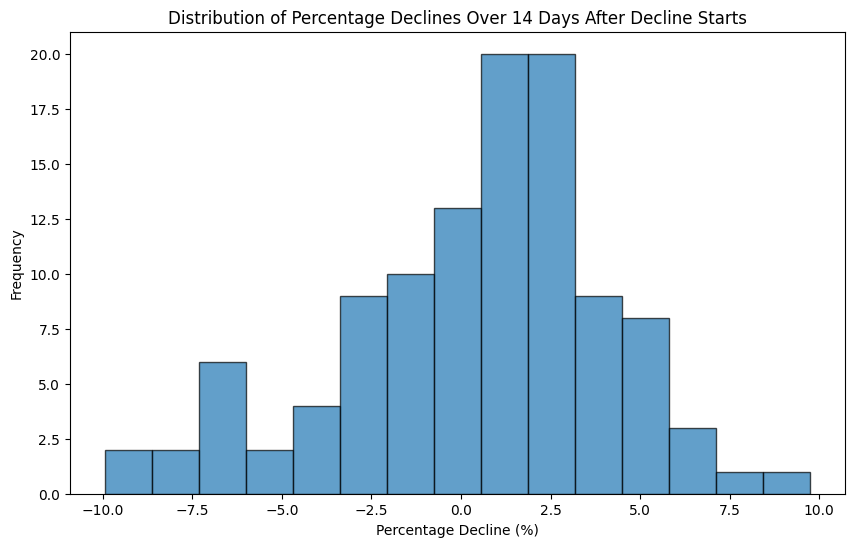

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical data for the past 10 years
ticker_symbol = '^NDX'
data = yf.download(ticker_symbol, period='10y')
data = data.dropna()

# Function to compute RSI
def computeRSI(data, time_window):
    diff = data.diff(1)
    gain = diff.clip(lower=0)
    loss = -1 * diff.clip(upper=0)
    avg_gain = gain.rolling(window=time_window, min_periods=1).mean()
    avg_loss = loss.rolling(window=time_window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI and add it to the DataFrame
data['RSI'] = computeRSI(data['Adj Close'], 14)

# Identify where RSI crosses above 70
data['RSI Overbought'] = np.where(
    (data['RSI'].shift(1) < 70) & (data['RSI'] >= 70), 1, 0)
overbought_dates = data[data['RSI Overbought'] == 1].index

# Set the parameters
search_period = 60  # days to look for the decline start
decline_period = 14  # days over which to measure the decline

# Initialize a list to store declines
declines = []

# Loop through each overbought date
for date in overbought_dates:
    search_end_date = date + pd.Timedelta(days=search_period)
    data_subset = data.loc[date:search_end_date]

    if not data_subset.empty:
        # Find the highest price after the overbought date
        peak_price = data_subset['Adj Close'].max()
        # Get all dates when the price was at its peak
        peak_dates = data_subset[data_subset['Adj Close'] == peak_price].index
        # Take the first occurrence
        peak_date = peak_dates[0]

        # From the peak date, find when the price starts to decline
        decline_data = data.loc[peak_date:search_end_date].copy()
        decline_data['Price Diff'] = decline_data['Adj Close'].diff()

        # Identify the first day when the price decreases
        decline_start = decline_data[decline_data['Price Diff'] < 0].index
        if not decline_start.empty:
            decline_start_date = decline_start[0]
            decline_end_date = decline_start_date + pd.Timedelta(days=decline_period)
            if decline_end_date in data.index:
                start_price = data.loc[decline_start_date]['Adj Close']
                end_price = data.loc[decline_end_date]['Adj Close']
                decline_percent = (end_price - start_price) / start_price * 100
                declines.append(decline_percent)

# Convert the list to a NumPy array
declines = np.array(declines)

# Calculate average and median declines
average_decline = np.mean(declines)
median_decline = np.median(declines)

print(f"Average percentage decline over {decline_period} days after decline starts: {average_decline:.2f}%")
print(f"Median percentage decline over {decline_period} days after decline starts: {median_decline:.2f}%")

# Plot the histogram
plt.figure(figsize=(10,6))
plt.hist(declines, bins=15, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of Percentage Declines Over {decline_period} Days After Decline Starts')
plt.xlabel('Percentage Decline (%)')
plt.ylabel('Frequency')
plt.show()
